In [31]:
import pandas as pd
import numpy as np

from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, Dense, TimeDistributed,\
                        LSTM, GRU, Bidirectional, SimpleRNN

import pickle

In [2]:
sheet_names = ['1', '2', '4']
data = pd.Series()

for s in sheet_names:
    x = pd.read_excel('entity_ext.xlsx', engine='openpyxl',
                      sheet_name=s, usecols='C', header=None, dtype=str)
    print(len(x))
    # print(x[2])
    data = data.append(x[2].dropna())

data

d:\onedrive - ada university\projects\python\freelancer\venv\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


18609
18610
18611


0        Salam men [albali kartin](card_type) limiti ar...
1                                                     Beli
2        <last_name> <first_name> <first_name> oglu <mo...
3                         Yaxsi coxsagolun tewekkur edirem
5                                                    Salam
                               ...                        
18606            Yeni [bir ilden sora](date) götürmek olar
18607    Xanim sizi yoruram lap deqiwlesdirmek istiyire...
18608    Salam [Albalinin](card_type) limitini artirmaq...
18609    Salam mende [albali plus](card_type) varimdi l...
18610    Salam [albali plus](card_type) limiti artirmaq...
Length: 53933, dtype: object

In [4]:
def transform_to_dataset(tagged_sentences):
    X, y = [], []
    count = 0

    for _, sentence in tagged_sentences.iteritems():

        # print(sentence)
        if len(sentence) < 2:
            continue

        count += 1

        # words = re.findall(r"\[(.*?)]", sentence)
        # tags = re.findall(r"\((.*?)\)", sentence)

        words = []
        tags = []
        i = j = 0

        try:
            while True:
                sentence = sentence[j:]
                i = sentence.index('[')
                j = sentence.index(']')

                if sentence[j + 1] != '(':  # no tag
                    raise

                words.append(sentence[i + 1:j])
                sentence = sentence[j + 1:]

                j = sentence.index(')')
                tags.append(sentence[1:j])

        except:
            pass

        # make sure their length are equal
        if len(words) != len(tags):
            print(_)
            print(sentence)
            print(words, tags)

        # print(w)
        X.append(words)
        y.append(tags)

    return X, y


sents, tags = transform_to_dataset(data)

In [5]:
num_words = len(set([word.lower() for sentence in sents for word in sentence]))
num_tags  = len(set([word.lower() for sentence in tags for word in sentence]))
print("Total number of tagged sentences: {}".format(len(sents)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 53039
Vocabulary size: 11339
Total number of tags: 21


In [6]:
# encode X
word_tokenizer = Tokenizer()              # instantiate tokeniser
word_tokenizer.fit_on_texts(sents)            # fit tokeniser on data
# use the tokeniser to encode input sequence
X_encoded = word_tokenizer.texts_to_sequences(sents)  


# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(tags)
Y_encoded = tag_tokenizer.texts_to_sequences(tags)

# look at first encoded data point


print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', sents[0], '\n')
print('Y: ', tags[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['albali kartin'] 

Y:  ['card_type'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [47] 

Y:  [2] 



In [7]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS’ pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.
# Truncation and padding can either be ‘pre’ or ‘post’. 
# For padding we are using ‘pre’ padding type, that is, add zeroes on the left side.
# For truncation, we are using ‘post’, that is, truncate a sentence from right side.
# sequences greater than 100 in length will be truncated
MAX_SEQ_LENGTH = 100
X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 47] 



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]


In [8]:
X, Y_nocat = X_padded, Y_padded
Y= to_categorical(Y_nocat)
Y.shape

(53039, 100, 22)

In [9]:

EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
NUM_CLASSES = Y.shape[2]

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))


In [10]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])
rnn_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          3402000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100, 64)           23360     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 22)           1430      
Total params: 3,426,790
Trainable params: 24,790
Non-trainable params: 3,402,000
_________________________________________________________________


In [11]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.10, random_state=42)
Xtrain, Xvalidation, ytrain, yvalidation = train_test_split(Xtrain, ytrain, test_size=0.10, random_state=42)

rnn_training = rnn_model.fit(Xtrain, ytrain, batch_size=128, epochs=10, validation_data=(Xvalidation, yvalidation))

Epoch 1/10
336/336 [==============================] - 57s 120ms/step - loss: 0.3543 - acc: 0.9714 - val_loss: 0.0419 - val_acc: 0.9937

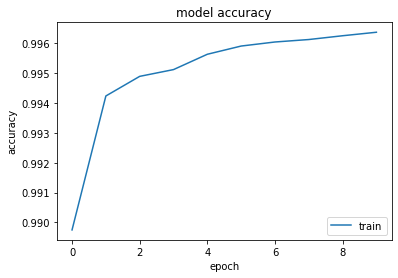

In [12]:
from matplotlib import pyplot as plt
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()


In [13]:
# LSTM

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         trainable     = False
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [14]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          3402000   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 64)           93440     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 22)           1430      
Total params: 3,496,870
Trainable params: 94,870
Non-trainable params: 3,402,000
_________________________________________________________________


In [15]:
lstm_training = lstm_model.fit(Xtrain, ytrain, batch_size=128, epochs=10, validation_data=(Xvalidation, yvalidation))

Epoch 1/10
336/336 [==============================] - 92s 253ms/step - loss: 0.5097 - acc: 0.9733 - val_loss: 0.0609 - val_acc: 0.9935

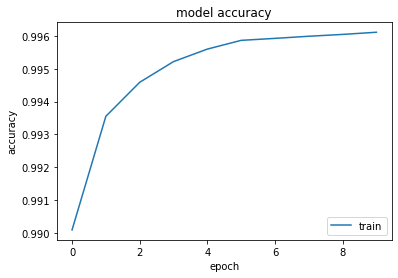

In [16]:
# visualise training history
plt.plot(lstm_training.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [17]:

gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        trainable     = False
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [18]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
# check summary of model
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          3402000   
_________________________________________________________________
gru (GRU)                    (None, 100, 64)           70272     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 100, 22)           1430      
Total params: 3,473,702
Trainable params: 71,702
Non-trainable params: 3,402,000
_________________________________________________________________


In [19]:
gru_training = gru_model.fit(Xtrain, ytrain, batch_size=128, epochs=10, validation_data=(Xvalidation, yvalidation))

Epoch 1/10
336/336 [==============================] - 65s 178ms/step - loss: 0.5483 - acc: 0.9744 - val_loss: 0.0318 - val_acc: 0.9935

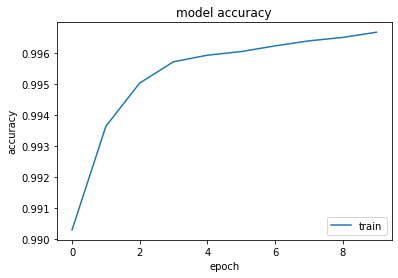

In [20]:
# visualise training history
plt.plot(gru_training.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [21]:

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             trainable     = False
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [22]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
# check summary of model
bidirect_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          3402000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          186880    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 100, 22)           2838      
Total params: 3,591,718
Trainable params: 189,718
Non-trainable params: 3,402,000
_________________________________________________________________


In [23]:
bidirect_training = bidirect_model.fit(Xtrain, ytrain, batch_size=128, epochs=30, validation_data=(Xvalidation, yvalidation))

Epoch 1/30
336/336 [==============================] - 122s 349ms/step - loss: 0.3659 - acc: 0.9923 - val_loss: 0.0226 - val_acc: 0.9935

In [24]:
loss, accuracy = rnn_model.evaluate(Xtest, ytest, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy*100))

166/166 [==============================] - 2s 12ms/step - loss: 0.0120 - acc: 0.9965

In [25]:
loss, accuracy = lstm_model.evaluate(Xtest, ytest, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy*100))

166/166 [==============================] - 4s 25ms/step - loss: 0.0129 - acc: 0.9962

In [26]:
# loss, accuracy = gru_model.evaluate(Xtest, ytest, verbose = 1)
# print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy*100))

In [27]:
loss, accuracy = bidirect_model.evaluate(Xtest, ytest, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy     * 100))

166/166 [==============================] - 7s 41ms/step - loss: 0.0077 - acc: 0.9979

In [28]:
bidirect_model.save('model/bi')
gru_model.save('model/gru')
lstm_model.save('model/lstm')
rnn_model.save('model/rnn')

with open('model/word.token', 'wb') as f:
    pickle.dump(word_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('model/tag.token', 'wb') as f:
    pickle.dump(tag_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)


INFO:tensorflow:Assets written to: model/bi\assets


INFO:tensorflow:Assets written to: model/bi\assets


INFO:tensorflow:Assets written to: model/gru\assets


INFO:tensorflow:Assets written to: model/gru\assets


INFO:tensorflow:Assets written to: model/lstm\assets


INFO:tensorflow:Assets written to: model/lstm\assets


INFO:tensorflow:Assets written to: model/rnn\assets


INFO:tensorflow:Assets written to: model/rnn\assets


In [29]:
ypred = np.argmax(bidirect_model.predict(Xtest), axis=-1)
ypred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 6],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
ytrue = np.argmax(ytest, axis=-1)
ytrue

In [ ]:
tag_tokenizer.sequences_to_texts(ypred) 

In [ ]:
tag_tokenizer.sequences_to_texts(ytest.argmax(2))

In [33]:
yy = rnn_model.predict([Xtest[0]])
# print(accuracy_score(ytest, yy))